# Measuring Mutual Information (MI) beteen EEG & MEG
- Measures shared information between two signals (in the information theory sense)
- Lets us know if the signal between eeg & meg shares resemblance.
- Formula: MI(X,Y) = Σ Σ P(x,y) * log₂(P(x,y)/(P(x)P(y)))



- Importing and loading the data.

# Import mean pooled data

# Sharding the data most probably fucks up my electrode indicies. Am I only saving the mag channels in shards? Investigate how they are saved!

In [6]:
import os
import torch
from pathlib import Path
import glob
from tqdm.notebook import tqdm
from dotenv import load_dotenv
import warnings

warnings.filterwarnings('ignore')

load_dotenv()
DATASET_PATH = os.getenv('DATASET_PATH')
def shift_tensor_forward(tensor, shift_steps=50):
    """
    Shift a tensor forward along the time dimension by 'shift_steps' frames, 
    using zero-padding at the initial frames.

    The tensor shape is assumed to be (channels, time, windows).

    Example:
        If shift_steps=100, samples originally at time t 
        will appear at time t+100 in the output. 
        The first 100 frames will be zeroed out.
    """
    # Create a zeroed tensor of the same shape
    shifted = torch.zeros_like(tensor)

    # Suppose shape is (C, T, W)
    # We'll shift along T dimension by 'shift_steps'
    if shift_steps < tensor.shape[1]:  # Ensure we don't exceed time dimension
        shifted[:, shift_steps:, :] = tensor[:, :-shift_steps, :]
    # If shift_steps >= T, shifted becomes all zeros (extreme case)

    return shifted

def load_and_concat_shards(dataset_path, mode='train', shift_meg=False, shift_steps=100):
    """
    Loads and concatenates all EEG and MAG shards from the specified dataset path and mode.
    Optionally shifts MEG signals forward by 'shift_steps' frames along the time dimension.
    
    Args:
        dataset_path (str): Path to the dataset root directory
        mode (str): One of 'train', 'val', or 'test'
        shift_meg (bool): Whether to shift the MEG data forward
        shift_steps (int): Number of frames to shift forward if shift_meg=True
    
    Returns:
        tuple: (concatenated_eeg, concatenated_mag) tensors
    """
    import os
    import torch
    from pathlib import Path
    from tqdm.notebook import tqdm
    
    # Initialize lists to store tensors
    eeg_tensors = []
    mag_tensors = []
    
    # Get all subject folders in the specified mode
    mode_path = Path(dataset_path) / mode
    subject_folders = sorted([f for f in mode_path.iterdir() if f.is_dir()])
    
    print(f"Loading {mode} data from {len(subject_folders)} subjects...")
    
    # Iterate through each subject folder
    for subject_folder in tqdm(subject_folders, desc="Loading subjects"):
        # Load EEG shards
        eeg_shard_folder = subject_folder / "EEG_shards"
        if eeg_shard_folder.exists():
            eeg_files = sorted(eeg_shard_folder.glob("*.pt"))
            for eeg_file in eeg_files:
                eeg_tensor = torch.load(eeg_file)
                eeg_tensors.append(eeg_tensor)
        
        # Load MAG shards
        mag_shard_folder = subject_folder / "MAG_shards"
        if mag_shard_folder.exists():
            mag_files = sorted(mag_shard_folder.glob("*.pt"))
            for mag_file in mag_files:
                mag_tensor = torch.load(mag_file)
                
                # If enabled, shift the MAG tensor forward in time
                if shift_meg:
                    mag_tensor = shift_tensor_forward(mag_tensor, shift_steps=shift_steps)
                
                mag_tensors.append(mag_tensor)
    
    # Concatenate all tensors
    if eeg_tensors:
        concatenated_eeg = torch.cat(eeg_tensors, dim=2)  # Concatenate along windows dimension
    else:
        concatenated_eeg = None
        
    if mag_tensors:
        concatenated_mag = torch.cat(mag_tensors, dim=2)  # Concatenate along windows dimension
    else:
        concatenated_mag = None
    
    return concatenated_eeg, concatenated_mag

# Example usage:
eeg_data, mag_data = load_and_concat_shards(DATASET_PATH, mode='train', shift_meg=True, shift_steps=100)

Loading train data from 11 subjects...


Loading subjects:   0%|          | 0/11 [00:00<?, ?it/s]

# (Temporary) - Printing the first 2750 frames EEG 13, MAG 21

In [2]:
# In a new cell, add something like this:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

# Make sure matplotlib displays inline in Jupyter
%matplotlib inline

@interact(
    time_frames=widgets.IntSlider(min=1, max=275, step=1, value=275, description='Time Frames'),
    window_index=widgets.IntSlider(min=0, max=0 if eeg_data is None else eeg_data.shape[2]-1, step=1, value=0, description='Window')
)
def dynamic_plot(time_frames, window_index):
    """
    Dynamically plot the first `time_frames` samples from EEG channel 13 and 
    MAG channel 21 for the requested window_index, using ipywidgets for 
    interactive sliders in a Jupyter Notebook.
    """
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    if eeg_data is not None:
        # EEG Channel 13
        eeg_slice = eeg_data[13, :time_frames, window_index].cpu().numpy() if eeg_data.is_cuda else eeg_data[13, :time_frames, window_index].numpy()
        axs[0].plot(eeg_slice, label='EEG Ch 13')
        axs[0].set_title(f'EEG channel 13 (Window {window_index})')
        axs[0].legend()

    if mag_data is not None:
        # MAG Channel 21
        mag_slice = mag_data[21, :time_frames, window_index].cpu().numpy() if mag_data.is_cuda else mag_data[21, :time_frames, window_index].numpy()
        axs[1].plot(mag_slice, label='MAG Ch 21', color='orange')
        axs[1].set_title(f'MAG channel 21 (Window {window_index})')
        axs[1].legend()

    axs[1].set_xlabel('Sample Index')
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=275, description='Time Frames', max=275, min=1), IntSlider(value=0, desc…

In [7]:
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np

# Make sure matplotlib displays inline in Jupyter
%matplotlib inline

def bandpass_filter(signal, sf, low_freq, high_freq):
    """
    Perform a simple bandpass filter in the frequency domain by FFT and 
    removing all frequency components outside [low_freq, high_freq].
    """
    n = len(signal)
    # Frequency array (for real FFT up to Nyquist)
    freqs = np.fft.rfftfreq(n, 1.0 / sf)
    # FFT of the signal
    fft_signal = np.fft.rfft(signal)
    # Zero out frequencies that are not in the desired band
    mask = (freqs >= low_freq) & (freqs <= high_freq)
    fft_signal[~mask] = 0
    # Reconstruct filtered signal via IFFT
    filtered = np.fft.irfft(fft_signal, n=n)
    return filtered

@interact(
    time_frames=widgets.IntSlider(min=1, max=275, step=1, value=250, description='Time Frames'),
    window_index=widgets.IntSlider(min=0, max=0 if eeg_data is None else eeg_data.shape[2]-1, step=1, value=0, description='Window')
)
def dynamic_six_subplots(time_frames, window_index):
    """
    Dynamically plot the alpha, beta, and gamma band-limited signals for EEG channel 13
    and MAG channel 21, each on its own subplot. That gives us 6 subplots in total:
    1) EEG Alpha
    2) EEG Beta
    3) EEG Gamma
    4) MAG Alpha
    5) MAG Beta
    6) MAG Gamma

    The number of time_frames and window_index can be adjusted with sliders.
    
    Alpha:  8-12 Hz
    Beta:   13-30 Hz
    Gamma:  31-80 Hz
    """
    sf = 250  # Sampling frequency (assumed or known)
    fig, axes = plt.subplots(6, 1, figsize=(10, 14), sharex=True)

    # Extract EEG data and apply filters
    if eeg_data is not None:
        eeg_slice = eeg_data[13, :time_frames, window_index]
        eeg_slice = eeg_slice.cpu().numpy() if eeg_data.is_cuda else eeg_slice.numpy()

        alpha_eeg = bandpass_filter(eeg_slice, sf, 8, 12)
        beta_eeg  = bandpass_filter(eeg_slice, sf, 13, 30)
        gamma_eeg = bandpass_filter(eeg_slice, sf, 31, 80)

        axes[0].plot(alpha_eeg, color='blue')
        axes[0].set_ylabel('EEG Alpha\n(8-12 Hz)')
        axes[0].set_title(f'EEG (Ch 13) - Window {window_index}')

        axes[1].plot(beta_eeg, color='orange')
        axes[1].set_ylabel('EEG Beta\n(13-30 Hz)')

        axes[2].plot(gamma_eeg, color='green')
        axes[2].set_ylabel('EEG Gamma\n(31-80 Hz)')

    # Extract MAG data and apply filters
    if mag_data is not None:
        mag_slice = mag_data[21, :time_frames, window_index]
        mag_slice = mag_slice.cpu().numpy() if mag_data.is_cuda else mag_slice.numpy()

        alpha_mag = bandpass_filter(mag_slice, sf, 8, 12)
        beta_mag  = bandpass_filter(mag_slice, sf, 13, 30)
        gamma_mag = bandpass_filter(mag_slice, sf, 31, 80)

        axes[3].plot(alpha_mag, color='blue')
        axes[3].set_ylabel('MAG Alpha\n(8-12 Hz)')
        axes[3].set_title(f'MAG (Ch 21) - Window {window_index}')

        axes[4].plot(beta_mag, color='orange')
        axes[4].set_ylabel('MAG Beta\n(13-30 Hz)')

        axes[5].plot(gamma_mag, color='green')
        axes[5].set_ylabel('MAG Gamma\n(31-80 Hz)')

    axes[-1].set_xlabel('Sample Index')
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=250, description='Time Frames', max=275, min=1), IntSlider(value=0, desc…

Importing fif files. Merging them. 

# Performing Fast Fourier Transform

In [8]:
# After loading eeg_data and mag_data with load_and_concat_shards(...)

# Safety checks:
if eeg_data is None or mag_data is None:
    raise ValueError("EEG and/or MAG data is None. Make sure data was loaded correctly.")

# Pick electrode 13 from EEG, electrode 65 from MAG.
# Shape is (channels, time, windows), so slicing a single channel produces (time, windows).
eeg_channel_13 = eeg_data[13, :, :]
mag_channel_21 = mag_data[21, :, :]

print("EEG channel 13 shape:", eeg_channel_13.shape)
print("MAG channel 21 shape:", mag_channel_21.shape)

# Convert to float if not already
eeg_channel_13 = eeg_channel_13.float()
mag_channel_65 = mag_channel_21.float()

# Compute the FFT across the 'time' dimension (dim=0 in the (time, windows) slice).
eeg_channel_13_fft = torch.fft.fft(eeg_channel_13, dim=0)
mag_channel_65_fft = torch.fft.fft(mag_channel_65, dim=0)

# Optionally compute magnitudes:
eeg_channel_13_magnitude = torch.abs(eeg_channel_13_fft)
mag_channel_65_magnitude = torch.abs(mag_channel_65_fft)

print("EEG channel 13 FFT shape:", eeg_channel_13_fft.shape)
print("MAG channel 65 FFT shape:", mag_channel_65_fft.shape)

# Example: print out a few values or stats
print("EEG channel 13, first few FFT magnitudes:", eeg_channel_13_magnitude[:, 0][:10])
print("MAG channel 65, first few FFT magnitudes:", mag_channel_65_magnitude[:, 0][:10])

EEG channel 13 shape: torch.Size([275, 25706])
MAG channel 21 shape: torch.Size([275, 25706])
EEG channel 13 FFT shape: torch.Size([275, 25706])
MAG channel 65 FFT shape: torch.Size([275, 25706])
EEG channel 13, first few FFT magnitudes: tensor([308.5042,  56.8744,  32.8842,  44.2654,  36.6277,  19.3213,   6.3360,
         15.2345,  11.4969,   9.3269])
MAG channel 65, first few FFT magnitudes: tensor([0.3263, 0.0494, 0.0603, 0.0390, 0.0308, 0.0426, 0.0598, 0.0295, 0.0604,
        0.0126])


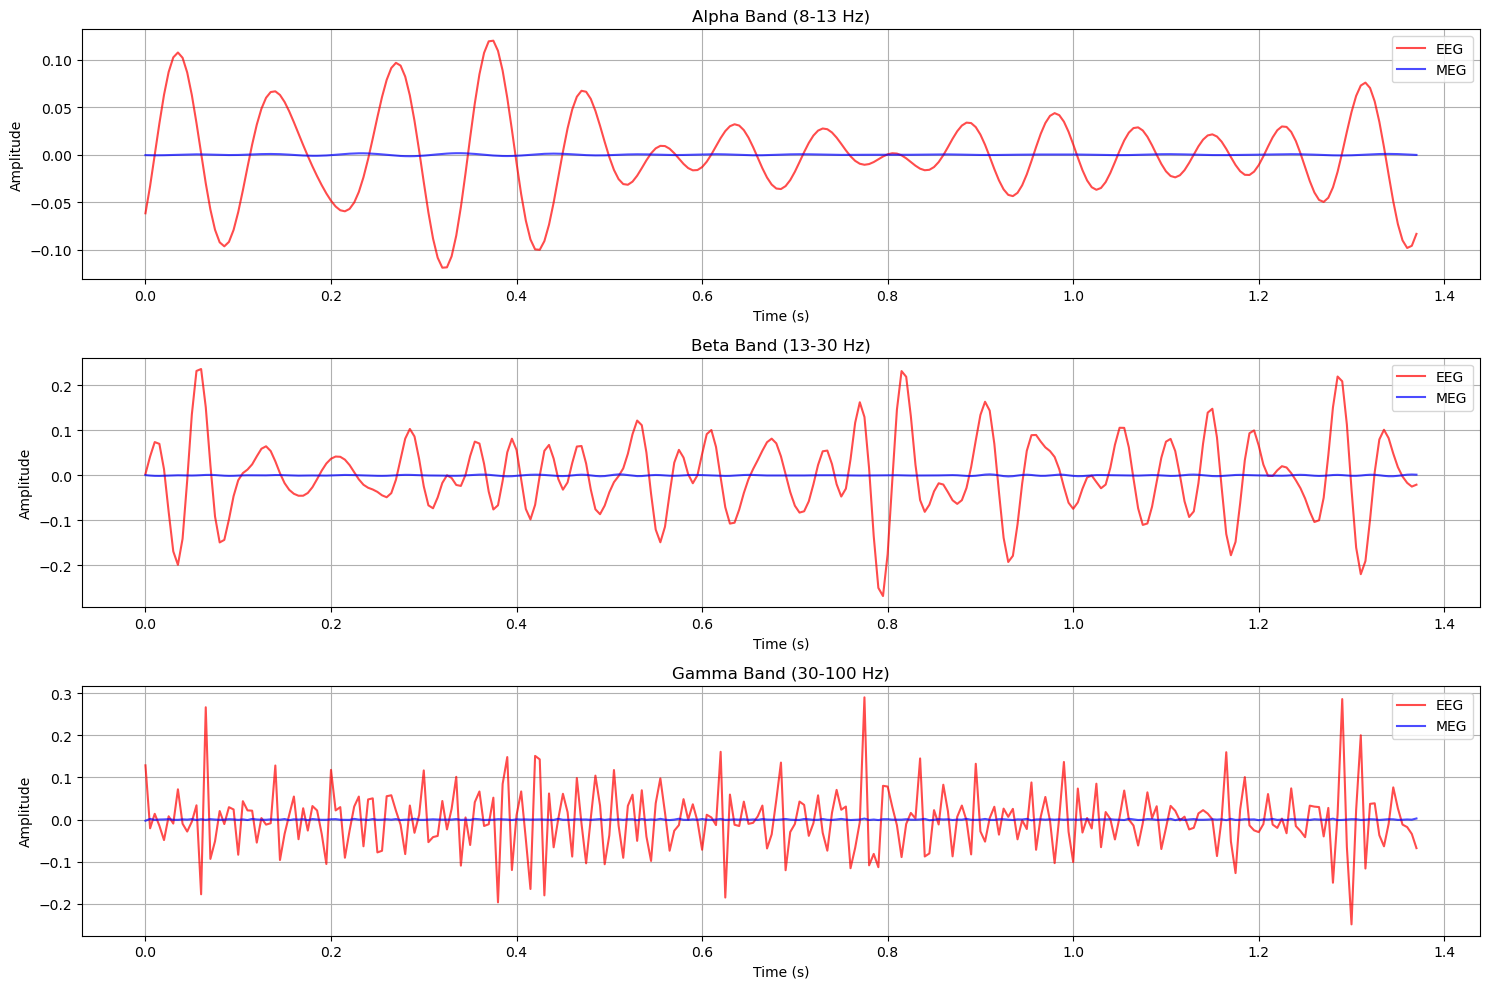


Alpha band statistics:
EEG - Mean: -0.000, Std: 0.142
MEG - Mean: -0.000, Std: 0.001

Beta band statistics:
EEG - Mean: 0.000, Std: 0.137
MEG - Mean: 0.000, Std: 0.001

Gamma band statistics:
EEG - Mean: 0.000, Std: 0.176
MEG - Mean: 0.000, Std: 0.002


# Split it into 8 Frequencies

# Compute MI

Computing global statistics:  36%|███▋      | 4/11 [00:06<00:11,  1.67s/it]

Error processing /srv/openfmri/train/sub-05/run_03.fif: buffer size must be a multiple of element size


Computing global statistics: 100%|██████████| 11/11 [00:18<00:00,  1.67s/it]



Processing files with global normalization...


Processing with global stats:   0%|          | 0/11 [00:00<?, ?it/s]

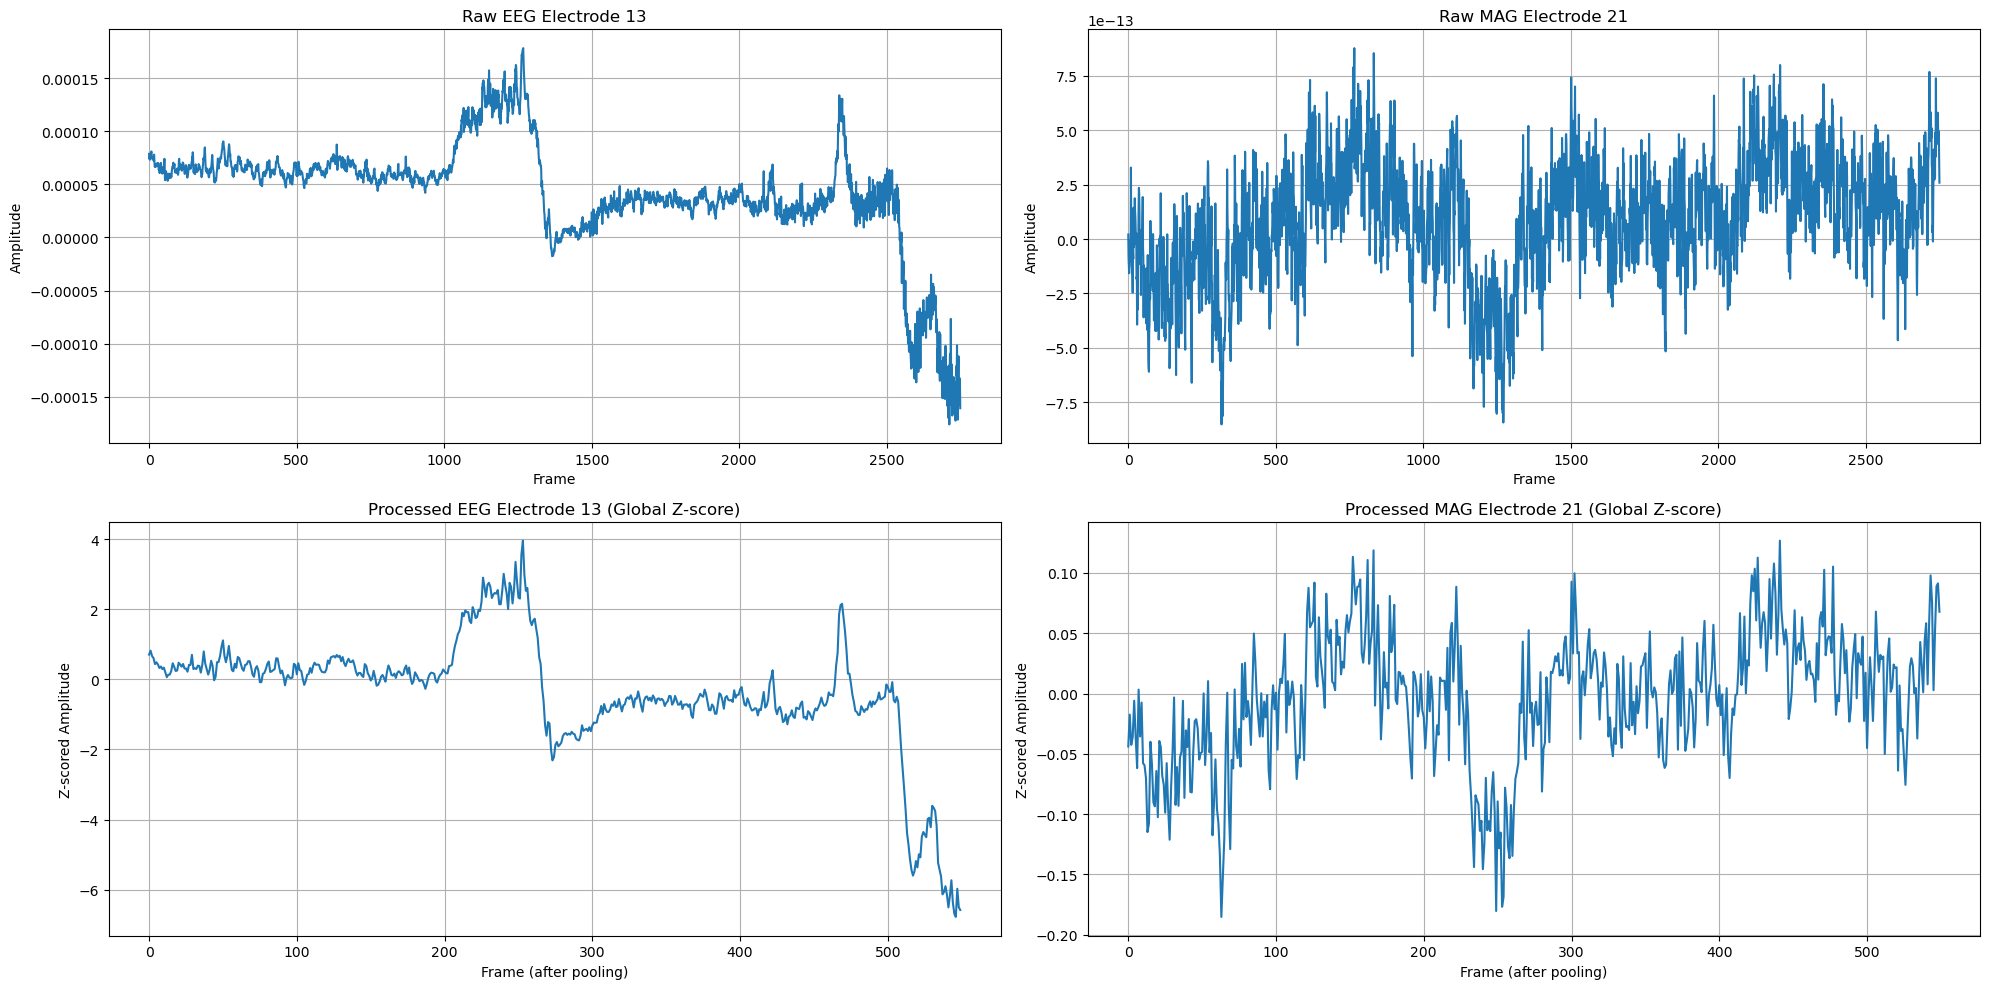

Processing with global stats:  36%|███▋      | 4/11 [00:07<00:12,  1.74s/it]

Error processing /srv/openfmri/train/sub-05/run_03.fif: buffer size must be a multiple of element size


Processing with global stats: 100%|██████████| 11/11 [00:18<00:00,  1.72s/it]



Final data shapes:
EEG data shape: (74, 1413830)
MAG data shape: (102, 1413830)


In [8]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings
from dotenv import load_dotenv
load_dotenv()
DATASET_PATH = os.getenv('DATASET_PATH')

warnings.filterwarnings("ignore", message=".*does not conform to MNE naming conventions.*")
mne.set_log_level("WARNING")

def mean_pool(data, pool_size=5):
    """Reduces temporal resolution by averaging every 'pool_size' samples."""
    n_channels, n_times = data.shape
    remainder = n_times % pool_size
    if remainder != 0:
        data = data[:, :(n_times - remainder)]
    data = data.reshape(n_channels, -1, pool_size)
    return data.mean(axis=-1)

def process_fif_files(dataset_path, mode="train"):
    """Process all .fif files in the specified mode folder."""
    mode_path = os.path.join(dataset_path, mode)
    all_eeg_data = []
    all_mag_data = []
    
    # Iterate through subjects
    subjects = sorted([f for f in os.listdir(mode_path) if os.path.isdir(os.path.join(mode_path, f))])
    for subject in tqdm(subjects, desc="Processing subjects"):
        subject_path = os.path.join(mode_path, subject)
        
        # Process each .fif file
        fif_files = [f for f in os.listdir(subject_path) if f.endswith('.fif')]
        for fif_file in fif_files:
            fif_path = os.path.join(subject_path, fif_file)
            
            try:
                # Read the file
                raw = mne.io.read_raw_fif(fif_path, preload=True)
                data = raw.get_data()
                
                # Separate EEG and MAG data
                eeg_indices = mne.pick_types(raw.info, meg=False, eeg=True)
                mag_indices = mne.pick_types(raw.info, meg='mag', eeg=False)
                
                eeg_data = data[eeg_indices, :]
                mag_data = data[mag_indices, :]
                
                # Mean pool the data
                eeg_pooled = mean_pool(eeg_data, pool_size=5)
                mag_pooled = mean_pool(mag_data, pool_size=5)
                
                all_eeg_data.append(eeg_pooled)
                all_mag_data.append(mag_pooled)
                
            except Exception as e:
                print(f"Error processing {fif_path}: {str(e)}")
                continue
    
    # Concatenate all data
    if all_eeg_data and all_mag_data:
        combined_eeg = np.concatenate(all_eeg_data, axis=1)
        combined_mag = np.concatenate(all_mag_data, axis=1)
        return combined_eeg, combined_mag
    else:
        return None, None

def plot_electrodes(eeg_data, mag_data, eeg_idx=13, mag_idx=21, n_frames=2750):
    """Plot specified electrodes for the first n_frames."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot EEG data
    ax1.plot(eeg_data[eeg_idx, :n_frames])
    ax1.set_title(f'EEG Electrode {eeg_idx}')
    ax1.set_xlabel('Frame')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True)
    
    # Plot MAG data
    ax2.plot(mag_data[mag_idx, :n_frames])
    ax2.set_title(f'MAG Electrode {mag_idx}')
    ax2.set_xlabel('Frame')
    ax2.set_ylabel('Amplitude')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Set your dataset path
    dataset_path = DATASET_PATH
    
    # Process the files
    print("Processing .fif files...")
    eeg_data, mag_data = process_fif_files(dataset_path, mode="train")
    
    if eeg_data is not None and mag_data is not None:
        print("\nData shapes:")
        print(f"EEG data shape: {eeg_data.shape}")
        print(f"MAG data shape: {mag_data.shape}")
        
        # Plot the specified electrodes
        print("\nPlotting electrodes...")
        plot_electrodes(eeg_data, mag_data)
    else:
        print("No data was processed successfully.")

In [5]:
import os
import torch
from pathlib import Path
import glob
from tqdm.notebook import tqdm
from dotenv import load_dotenv
import warnings

warnings.filterwarnings('ignore')

load_dotenv()
DATASET_PATH = os.getenv('DATASET_PATH')

# ONLY IMPLEMENTS TRAINING DATA ATM
def load_and_concat_shards(dataset_path, mode='train'):
    """
    Loads and concatenates all EEG and MAG shards from the specified dataset path and mode.
    
    Args:
        dataset_path (str): Path to the dataset root directory
        mode (str): One of 'train', 'val', or 'test'
    
    Returns:
        tuple: (concatenated_eeg, concatenated_mag) tensors
    """
    # Initialize lists to store tensors
    eeg_tensors = []
    mag_tensors = []
    
    # Get all subject folders in the specified mode
    mode_path = Path(dataset_path) / mode
    subject_folders = sorted([f for f in mode_path.iterdir() if f.is_dir()])
    
    print(f"Loading {mode} data from {len(subject_folders)} subjects...")
    
    # Iterate through each subject folder
    for subject_folder in tqdm(subject_folders, desc="Loading subjects"):
        # Load EEG shards
        eeg_shard_folder = subject_folder / "EEG_shards"
        if eeg_shard_folder.exists():
            eeg_files = sorted(eeg_shard_folder.glob("*.pt"))
            for eeg_file in eeg_files:
                eeg_tensor = torch.load(eeg_file)
                eeg_tensors.append(eeg_tensor)
        
        # Load MAG shards
        mag_shard_folder = subject_folder / "MAG_shards"
        if mag_shard_folder.exists():
            mag_files = sorted(mag_shard_folder.glob("*.pt"))
            for mag_file in mag_files:
                mag_tensor = torch.load(mag_file)
                mag_tensors.append(mag_tensor)
    
    # Concatenate all tensors
    if eeg_tensors:
        concatenated_eeg = torch.cat(eeg_tensors, dim=2)  # Concatenate along windows dimension
    else:
        concatenated_eeg = None
        
    if mag_tensors:
        concatenated_mag = torch.cat(mag_tensors, dim=2)  # Concatenate along windows dimension
    else:
        concatenated_mag = None
    
    return concatenated_eeg, concatenated_mag

# Load and concatenate the data
dataset_path = DATASET_PATH  # Adjust this path as needed
eeg_data, mag_data = load_and_concat_shards(dataset_path, mode='train')

# Print information about the tensors
print("\nData shapes:")
if eeg_data is not None:
    print(f"EEG data: {eeg_data.shape}")
    print(f"  - {eeg_data.shape[0]} channels")
    print(f"  - {eeg_data.shape[1]} timepoints per window")
    print(f"  - {eeg_data.shape[2]} total windows")
    print(f"  - dtype: {eeg_data.dtype}")
else:
    print("No EEG data found")

if mag_data is not None:
    print(f"\nMAG data: {mag_data.shape}")
    print(f"  - {mag_data.shape[0]} channels")
    print(f"  - {mag_data.shape[1]} timepoints per window")
    print(f"  - {mag_data.shape[2]} total windows")
    print(f"  - dtype: {mag_data.dtype}")
else:
    print("No MAG data found")

# Optional: Print some basic statistics
if eeg_data is not None:
    print("\nEEG Statistics:")
    print(f"Mean: {eeg_data.float().mean():.3f}")
    print(f"Std: {eeg_data.float().std():.3f}")
    print(f"Min: {eeg_data.float().min():.3f}")
    print(f"Max: {eeg_data.float().max():.3f}")

if mag_data is not None:
    print("\nMAG Statistics:")
    print(f"Mean: {mag_data.float().mean():.3f}")
    print(f"Std: {mag_data.float().std():.3f}")
    print(f"Min: {mag_data.float().min():.3f}")
    print(f"Max: {mag_data.float().max():.3f}")

Loading train data from 11 subjects...


Loading subjects:   0%|          | 0/11 [00:00<?, ?it/s]


Data shapes:
EEG data: torch.Size([74, 275, 25706])
  - 74 channels
  - 275 timepoints per window
  - 25706 total windows
  - dtype: torch.float16

MAG data: torch.Size([102, 275, 25706])
  - 102 channels
  - 275 timepoints per window
  - 25706 total windows
  - dtype: torch.float16

EEG Statistics:
Mean: 0.001
Std: 1.049
Min: -122.562
Max: 77.312

MAG Statistics:
Mean: -0.000
Std: 0.060
Min: -5.055
Max: 4.867
